In [30]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
from scipy.stats import distributions

import os
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
from utils import *
import warnings
from matplotlib import transforms

In [2]:
def ClausiusClapeyron(tas_data):
    numerator = 17.76*tas_data
    denominator = tas_data + 243.5
    svp = .6112 * np.exp(numerator/denominator)
    return svp

In [3]:
def VPD(hurs_data, tas_data):
    svp = ClausiusClapeyron(tas_data)
    vpd = ((1-hurs_data['hurs']/100) * svp)/1000    # /1000 converts to kPa
    return vpd

In [4]:
# List of dataset to use for training
train_files = ["hist-GHG", "hist-aer",'historical']

data_path = os.getcwd() + "/"

min_co2 = 0.
max_co2 = 9500
def normalize_co2(data):
    return data / max_co2

min_ch4 = 0.
max_ch4 = 0.8
def normalize_ch4(data):
    return data / max_ch4

In [5]:
def create_predictor_data1(data_sets, n_eofs=5):
    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]
    X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    X = X.assign_coords(time=np.arange(len(X.time)))

    # Compute EOFs for BC
    bc_solver = Eof(X['BC'])
    bc_eofs = bc_solver.eofsAsCorrelation(neofs=n_eofs)
    bc_pcs = bc_solver.pcs(npcs=n_eofs, pcscaling=1)

    # Compute EOFs for SO2
    so2_solver = Eof(X['SO2'])
    so2_eofs = so2_solver.eofsAsCorrelation(neofs=n_eofs)
    so2_pcs = so2_solver.pcs(npcs=n_eofs, pcscaling=1)

    # Convert to pandas
    bc_df = bc_pcs.to_dataframe().unstack('mode')
    bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

    so2_df = so2_pcs.to_dataframe().unstack('mode')
    so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]

    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": normalize_co2(X["CO2"].data),
        "CH4": normalize_ch4(X["CH4"].data)
    }, index=X["CO2"].coords['time'].data)

    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)
    return inputs, (so2_solver, bc_solver)

In [6]:
def create_predictdand_data(data_sets):
    if isinstance(data_sets, str):
        data_sets = [data_sets]
    tas_y = xr.concat([xr.open_dataset(data_path + f"tas_{file}.nc") 
               for file in data_sets], dim='time')
    hurs_y = xr.concat([xr.open_dataset(data_path + f"hurs_{file}.nc") 
                   for file in data_sets], dim='time')
    
    Y = tas_y.merge(hurs_y)
    vpd = VPD(hurs_y,tas_y)
    Y = Y.assign(vpd=vpd['tas'])
    return Y

In [7]:
def get_test_data(file, eof_solvers, n_eofs=5):
    # Create training and testing arrays
    X = xr.open_dataset(data_path + f"inputs_{file}.nc")
        
    so2_pcs = eof_solvers[0].projectField(X["SO2"], neofs=5, eofscaling=1)
    so2_df = so2_pcs.to_dataframe().unstack('mode')
    so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]

    bc_pcs = eof_solvers[1].projectField(X["BC"], neofs=5, eofscaling=1)
    bc_df = bc_pcs.to_dataframe().unstack('mode')
    bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": normalize_co2(X["CO2"].data),
        "CH4": normalize_ch4(X["CH4"].data)
    }, index=X["CO2"].coords['time'].data)

    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)
    return inputs

In [8]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth - pred)**2).weighted(weights).mean(['lat', 'lon'])).data

In [9]:
def vpdGP():
    # Create training and testing arrays
    X_train, eof_solvers = create_predictor_data1(train_files)
    y_train_vpd = create_predictdand_data(train_files)['vpd'].values.reshape(-1, 96 * 144)
    
    X_test = get_test_data('ssp245', eof_solvers)
    Y_test = create_predictdand_data('ssp245')
    vpd_truth = Y_test["vpd"]
    
    # Drop rows including nans
    nan_train_mask = X_train.isna().any(axis=1).values
    X_train = X_train.dropna(axis=0, how='any')
    y_train_vpd = y_train_vpd[~nan_train_mask]
    assert len(X_train) == len(y_train_vpd)
    nan_test_mask = X_test.isna().any(axis=1).values
    X_test = X_test.dropna(axis=0, how='any')
    vpd_truth = vpd_truth[~nan_test_mask]

    # Standardize predictor fields requiring standardization (non-EOFs)
    train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
    train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()
    X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
    X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std
    X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
    X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

    # Standardize predictand fields
    train_vpd_mean, train_vpd_std = y_train_vpd.mean(), y_train_vpd.std()
    y_train_vpd = (y_train_vpd - train_vpd_mean) / train_vpd_std

    # Make kernel
    kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
    kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])
    kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
    kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])
    kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

    # Make model
    np.random.seed(5)
    mean = gpflow.mean_functions.Constant()
    model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                    y_train_vpd.astype(np.float64)),
                              kernel=kernel,
                              mean_function=mean)

    # Define optimizer
    opt = gpflow.optimizers.Scipy()
    # Train model
    opt.minimize(model.training_loss,
                 variables=model.trainable_variables,
                 options=dict(disp=True, maxiter=1000))

    # predict
    standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
    posterior_mean = standard_posterior_mean * train_vpd_std + train_vpd_mean
    posterior_stddev = np.sqrt(standard_posterior_var) * train_vpd_std

    # put output back into xarray format for calculating RMSE/plotting
    posterior_vpd = np.reshape(posterior_mean, [86, 96, 144])
    posterior_vpd_stddev = np.reshape(posterior_stddev, [86, 96, 144])
    
    posterior_vpd_data = xr.DataArray(posterior_vpd, dims=vpd_truth.dims, coords=vpd_truth.coords)
    posterior_vpd_std_data = xr.DataArray(posterior_vpd_stddev, dims=vpd_truth.dims, coords=vpd_truth.coords)

    # Compute RMSEs
    print(f"RMSE at 2050: {get_rmse(vpd_truth[35], posterior_vpd_data[35])}")
    print(f"RMSE at 2100: {get_rmse(vpd_truth[85], posterior_vpd_data[85])}")
    print(f"RMSE 2045-2055: {get_rmse(vpd_truth[30:41], posterior_vpd_data[30:41]).mean()}")
    print(f"RMSE 2090-2100: {get_rmse(vpd_truth[75:], posterior_vpd_data[75:]).mean()}")
    print(f"RMSE 2050-2100: {get_rmse(vpd_truth[35:], posterior_vpd_data[35:]).mean()}")
    
    # RMSE for average field over last 20 years
    print(f"RMSE average last 20y: {get_rmse(vpd_truth[-20:].mean(dim='time'), posterior_vpd_data[-20:].mean(dim='time'))}")

    # plotting predictions
    divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
    diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)
    
    ## Temperature
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(18, 3))
    fig.suptitle('Vapor Pressure Deficit')
    
    # Test
    plt.subplot(131, projection=proj)
    vpd_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                                  cbar_kwargs={"label":"VPD Change / kPa"})
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='True')
    
    # Emulator
    plt.subplot(132, projection=proj)
    posterior_vpd_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                           cbar_kwargs={"label":"VPD Change / kPa"})
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='GP posterior mean')
    
    # Difference
    difference = vpd_truth - posterior_vpd_data
    plt.subplot(133, projection=proj)
    difference.sel(time=slice(2050,None)).mean('time').plot(
        cmap="bwr",norm=diffnorm,cbar_kwargs={"label":"VPD Change / kPa"})
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='Difference')
    return posterior_vpd_data

2024-03-10 17:29:59.575498: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.33729D+06    |proj g|=  1.86434D+06


 This problem is unconstrained.



At iterate    1    f= -6.30220D+06    |proj g|=  1.55291D+06

At iterate    2    f= -6.80061D+06    |proj g|=  3.85030D+05

At iterate    3    f= -8.39981D+06    |proj g|=  4.49664D+05

At iterate    4    f= -1.03549D+07    |proj g|=  3.10573D+06

At iterate    5    f= -1.13946D+07    |proj g|=  9.74439D+04

At iterate    6    f= -1.14233D+07    |proj g|=  8.04936D+04

At iterate    7    f= -1.14892D+07    |proj g|=  2.05668D+04

At iterate    8    f= -1.15130D+07    |proj g|=  2.10309D+04

At iterate    9    f= -1.15266D+07    |proj g|=  1.26063D+04

At iterate   10    f= -1.15391D+07    |proj g|=  1.42060D+04

At iterate   11    f= -1.15715D+07    |proj g|=  2.29531D+04

At iterate   12    f= -1.15862D+07    |proj g|=  1.46675D+04

At iterate   13    f= -1.15983D+07    |proj g|=  1.00763D+04

At iterate   14    f= -1.16033D+07    |proj g|=  5.94709D+03

At iterate   15    f= -1.16062D+07    |proj g|=  4.04976D+03

At iterate   16    f= -1.16062D+07    |proj g|=  6.88250D+03

At iter

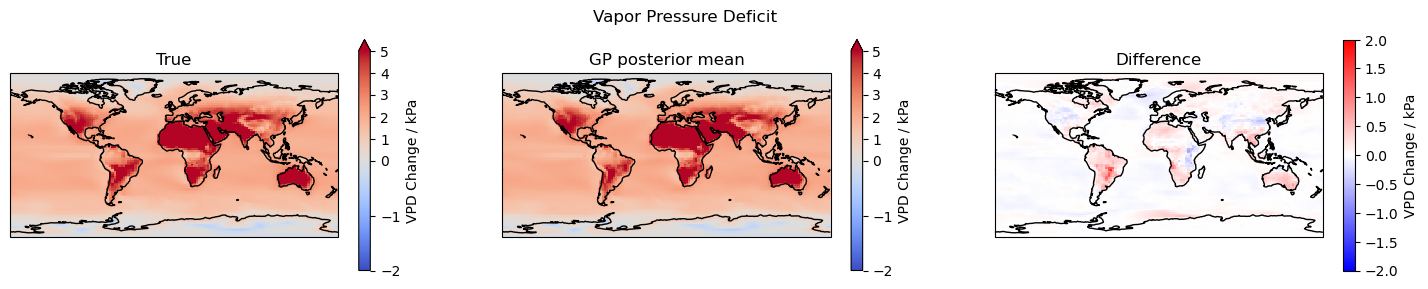

In [10]:
vpd_preds = vpdGP()

In [22]:
# functions to compute various NRMSEs
def get_nrmse_spatial(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    truth = truth.sel(time=slice(2080,None))
    pred = pred[-21:]
    truth_total = np.abs(truth.weighted(weights).mean(['lat', 'lon']).data.mean())
    rmse_spatial = np.sqrt(((truth - pred).mean('time')**2).weighted(weights).mean(['lat','lon'])).data
    return rmse_spatial / truth_total 

def get_nrmse_global(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    truth = truth.sel(time=slice(2080,None))
    pred = pred[-21:]
    truth_total = np.abs(truth.weighted(weights).mean(['lat', 'lon']).data.mean())
    rmse_global = np.sqrt((((truth - pred).weighted(weights).mean(['lat', 'lon']))**2).data.mean())
    return rmse_global / truth_total 

def get_nrmse(truth, pred):
    return get_nrmse_spatial(truth, pred) + 5 * get_nrmse_global(truth, pred)

In [23]:
# computes t-test for differences
def ttest_rel_from_stats(diff_mean, diff_std, diff_num):
    z = diff_mean / np.sqrt(diff_std ** 2 / diff_num)
    p = distributions.t.sf(np.abs(z), diff_num - 1) * 2
    return z, p

In [24]:
Y_test = create_predictdand_data('ssp245')
vpd_truth = Y_test["vpd"]

In [25]:
nrmses = [[
        get_nrmse_spatial(vpd_preds, vpd_truth), 
        get_nrmse_global(vpd_preds, vpd_truth),
        get_nrmse(vpd_preds, vpd_truth)
]]

nrmse_table = pd.DataFrame(data=nrmses, index=['vpd'], columns=['spatial', 'global', 'total']).round(3)
nrmse_table

,spatial,global,total
vpd,0.067,0.014,0.137


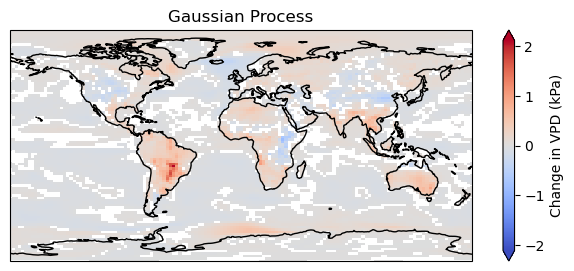

In [50]:
Y_test = create_predictdand_data('ssp245')
vpd_truth = Y_test["vpd"]
proj = ccrs.PlateCarree()
difference = vpd_truth - vpd_preds
diff_mean = difference.sel(time=slice(2080,2100)).mean('time')
plt.figure(figsize=(8,3))
plt.subplot(projection=proj)
_, p = ttest_rel_from_stats(diff_mean, difference.std('time'), difference.count('time'))
diff_mean = diff_mean.where(p<0.05)
diff_mean.plot(
        cmap="coolwarm",cbar_kwargs={"label":"Change in VPD (kPa)",'extend':'both'})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Gaussian Process');
plt.savefig("gpDiff.pdf")

In [37]:
p<0.05

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False,  True,  True, ...,  True, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])